# Step 2
Il nostro obiettivo è quello di ricercare il canale raro 
$$q\bar q \rightarrow g \rightarrow t\bar t \rightarrow Wb+Wb \rightarrow l\nu b + l\nu b$$
A tale scopo seguirò i seguenti passaggi:
* L'idea è di ritrovare un segnale all'energia di circa $344 GeV$
    + Ciò è dovuto al fatto che il quark top ha energia di circa $170GeV$
    + Per il nostro segnale, nei dati, sappiamo che il fondo principale è dato dalla risonanza della $Z^0$
        - A causa di ciò consideriamo, prima di poter effettuare i tagli e prima di studiare il dataset d'interesse, i file TTDilep e DYJets rispettivamente come campione di segnale e di fondo così da sapepre come effettuare una selezione
* Procediamo con la selezione e l'analisi del segnale
    + consideriamo solo i casi in cui ho almeno 2 muoni, altrimenti posso già scartare tutto
        - I muoni devono essere passing probes col cut deciso nello step 1 così da avere efficienza del 90%: 
        $$dz <0.014 \qquad dB<0.007 \qquad isoDeposits < 9$$ 
    + Dobbiamo considerare la selezione sui muoni ricavata dallo step 1, fatta col tag&probe
    + Dobbiamo riuscire a capire quanto le variabili che abbiamo siano discriminanti per il fondo. Per farlo abbiamo utilizzato:
        - Numero di jets
        - muon_dz
        - muon_dB
        - jets energy
        - muon pt
        - jets pt
        - met pt

In [1]:
import ROOT
import particle as pt
import funx as fx
import numpy as np

filett = ROOT.TFile("./datas/TTDilep.root","OPEN")
tttr = filett.trees.events

fileDY = ROOT.TFile("./datas/DYJets.root","OPEN")
dytr = fileDY.trees.events

Welcome to JupyROOT 6.26/04


In [ ]:
#jets
h_tt_jsz=ROOT.TH1F("Jet_size", "Jet Size", 100, 0 , 10)
h_dy_jsz=ROOT.TH1F("Jet_size", "Jet Size", 100, 0 , 10)
h_tt_je=ROOT.TH1F("Jet_e", "Jet e", 40, 20 , 200)
h_dy_je=ROOT.TH1F("Jet_e", "Jet e", 40, 20 , 200)
h_tt_jpt=ROOT.TH1F("Jet_pt", "Jet pt", 80, 20 , 150)
h_dy_jpt=ROOT.TH1F("Jet_pt", "Jet pt", 80, 20 , 150)
#met
h_tt_met=ROOT.TH1F("met", "MET pt", 50, 0 , 200)
h_dy_met=ROOT.TH1F("met", "MET pt", 50, 0 , 200)
#muoni
h_dz_dy=ROOT.TH1F("mu_dz", "mu_dz", 80, 0, 0.01)
h_dz_tt=ROOT.TH1F("mu_dz", "mu_dz", 80, 0, 0.01)
h_dB_dy=ROOT.TH1F("mu_dB", "mu_dB", 80, 0, 0.006)
h_dB_tt=ROOT.TH1F("mu_dB", "mu_dB", 80, 0, 0.006)
h_iD_dy=ROOT.TH1F("mu_iD", "mu_iD", 80, 0.1, 10)
h_iD_tt=ROOT.TH1F("mu_iD", "mu_iD", 80, 0.1, 10)
h_m_dy=ROOT.TH1F("two_mu_mass", "mu_mass", 90, 0, 120)
h_m_tt=ROOT.TH1F("two_mu_mass", "mu_mass", 90, 0, 120)

arr = [[h_tt_jsz, h_dy_jsz],[h_tt_je,h_dy_je], [h_tt_jpt,h_dy_jpt], [h_tt_met,h_dy_met], [h_dz_tt,h_dz_dy],[h_dB_tt,h_dB_dy], [h_iD_tt,h_iD_dy],[h_m_tt,h_m_dy]]

for i in range(tttr.GetEntries()):
    tttr.GetEntry(i)
    if(tttr.muontracks_size >=2):
        muons = pt.get_collection(tttr, "muontracks")
        passing = 0
        for mi in range(len(muons)):
            if(tttr.muontracks_dz[mi]<0.005 and tttr.muontracks_dB[mi]<0.003 and tttr.muontracks_isoDeposits[mi]<4):
                for mj in range(len(muons)):
                    if(mi!=mj and tttr.muontracks_dz[mj]<0.014 and tttr.muontracks_dB[mj]<0.007 and tttr.muontracks_isoDeposits[mj]<9):
                        passing = 1
                        s_mu = (muons[mi].p4+muons[mj].p4).M()
                        h_m_tt.Fill(s_mu)
                        """if(tttr.muontracks_dz[mj]>0.005 and tttr.muontracks_dB[mj]>0.003 and tttr.muontracks_isoDeposits[mj]>4):         #Voglio prendere un tag ed un probe NON tag
                            s_mu = (muons[mi].p4+muons[mj].p4).M()
                            h_m_tt.Fill(s_mu)"""

        if(passing==1):
            #Taglio in distanza angolare jets-leptons + solo 2 jets più energetici
            jets = pt.get_collection(tttr, "jets") 
            if(len(jets)>=2):
                clean_jets = []             #jets con distanza angolare che ci piace
                sel_j = []                  #solo i 2 più energetici di ogni clean_jets
                for jj in range(len(jets)): #Selezione jets validi
                    dists=[]                #array di distanze angolari
                    for mm in range(len(muons)):
                        d = ROOT.TMath.Sqrt( ((muons[mm].eta - jets[jj].eta)*(muons[mm].eta - jets[jj].eta)) + ((muons[mm].phi - jets[jj].phi)*(muons[mm].phi -jets[jj].phi)) )
                        dists.append(d)
                    if(min(dists) > 0.4):
                        clean_jets.append(jets[jj])
                if(len(clean_jets)>1):              #non ha senso considerare l'evento se nella selezione resta un solo jet
                    for p in range(2):              #solo 2 per evento
                        sel_j.append(clean_jets[p]) #questi sono i jets che ci piacciono

                    h_tt_jsz.Fill(tttr.jets_size)
                    h_tt_met.Fill(tttr.met_pt[0])

                    for jet in range(len(sel_j)):
                        h_tt_je.Fill(sel_j[jet].e)
                        h_tt_jpt.Fill(sel_j[jet].pt)
                    
                    

                    for m in range(tttr.muontracks_size):   #non ha senso considerare i casi dove ho jets non validi
                        h_dz_tt.Fill(tttr.muontracks_dz[m]) #quindi stampo i muoni solo se ho i jets validi
                        h_dB_tt.Fill(tttr.muontracks_dB[m]) #esattamente come ho stampato i jets solo dopo il tag & probe
                        #h_pt_tt.Fill(tttr.muontracks_pt[m])
                        h_iD_tt.Fill(tttr.muontracks_isoDeposits[m])

for k in range(dytr.GetEntries()):             #stesso ciclo di prima, ma sull'altro tree
    dytr.GetEntry(k)
    if(dytr.muontracks_size >=2):
        muons = pt.get_collection(dytr, "muontracks")
        passing = 0
        for mi in range(len(muons)):
            if(dytr.muontracks_dz[mi]<0.005 and dytr.muontracks_dB[mi]<0.003 and dytr.muontracks_isoDeposits[mi]<4):
                for mj in range(len(muons)):
                    if(mi!=mj and dytr.muontracks_dz[mj]<0.014 and dytr.muontracks_dB[mj]<0.007 and dytr.muontracks_isoDeposits[mj]<9): 
                        passing = 1
                        s_mu = (muons[mi].p4+muons[mj].p4).M()
                        h_m_dy.Fill(s_mu)
                        """if(dytr.muontracks_dz[mj]>0.005 and dytr.muontracks_dB[mj]>0.003 and dytr.muontracks_isoDeposits[mj]>4):         #Voglio prendere un tag ed un probe NON tag
                            s_mu = (muons[mi].p4+muons[mj].p4).M()
                            h_m_dy.Fill(s_mu)"""
                        
        if(passing==1):
            #Taglio in distanza angolare jets-leptons + solo 2 jets più energetici
            jets = pt.get_collection(dytr, "jets") 
            if(len(jets)>=2):
                clean_jets = []
                sel_j = []
                for jj in range(len(jets)):
                    dists=[]
                    for mm in range(len(muons)):
                        d = ROOT.TMath.Sqrt( ((muons[mm].eta - jets[jj].eta)*(muons[mm].eta - jets[jj].eta)) + ((muons[mm].phi - jets[jj].phi)*(muons[mm].phi -jets[jj].phi)) )
                        dists.append(d)
                    if(min(dists) > 0.4):
                        clean_jets.append(jets[jj])
                if(len(clean_jets)>1):
                    for p in range(2):
                        sel_j.append(clean_jets[p])

                    h_dy_jsz.Fill(dytr.jets_size)
                    h_dy_met.Fill(dytr.met_pt[0])

                    for jet in range(len(sel_j)):
                        h_dy_je.Fill(sel_j[jet].e)
                        h_dy_jpt.Fill(sel_j[jet].pt)
                    for m in range(dytr.muontracks_size):
                        h_dz_dy.Fill(dytr.muontracks_dz[m])
                        h_dB_dy.Fill(dytr.muontracks_dB[m])
                        #h_m_dy.Fill(dytr.muontracks_pt[m])
                    #for z in range(dytr.muontracks_size):
                        h_iD_dy.Fill(dytr.muontracks_isoDeposits[m])

c=list(np.zeros(8))
h_tts=[]
h_dys=[]
for i in arr:
    h_tts.append(i[0])
    h_dys.append(i[1])
for i in range(8):
    c[i]=ROOT.TCanvas()
    c[i].Draw()
    h_tts[i].Scale(1/h_tts[i].Integral())
    h_dys[i].Scale(1/h_dys[i].Integral())
    h_dys[i].Draw("hist")
    h_tts[i].SetLineColor(ROOT.kRed)
    h_tts[i].Draw("SAME,hist")

Dopo questa analisi preliminare possiamo quindi stabilire che i tagli sensati siano solo i seguenti
$$P_{T,MET}\geq 35$$
$$P_{T,jet}\geq 45$$
$$E_{jet}\geq 50$$

---

Prima di proseguire con questi tagli però verifichiamo che abbiano ancora senso facendo un taglio attorno alla massa dei muoni 

Warning in <TFile::Append>: Replacing existing TH1: Jet_e (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Jet_pt (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: met (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: two_mu_mass (Potential memory leak).


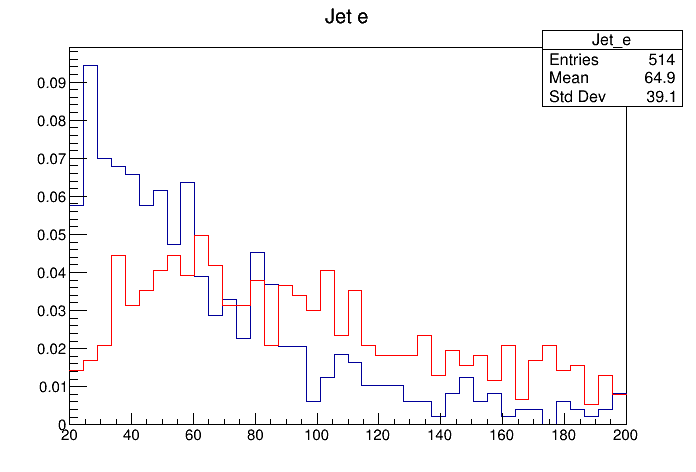

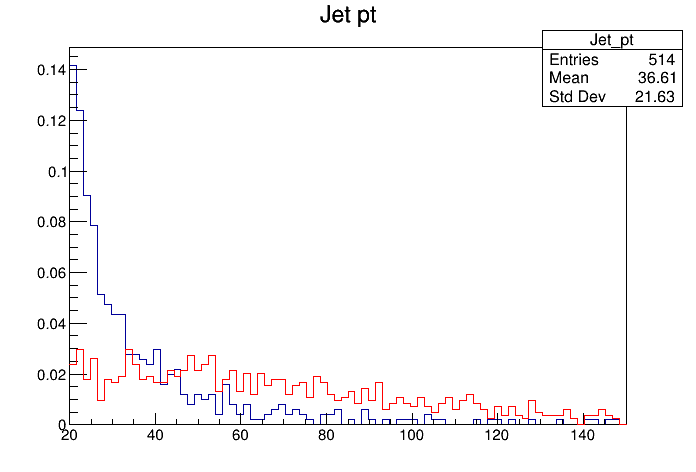

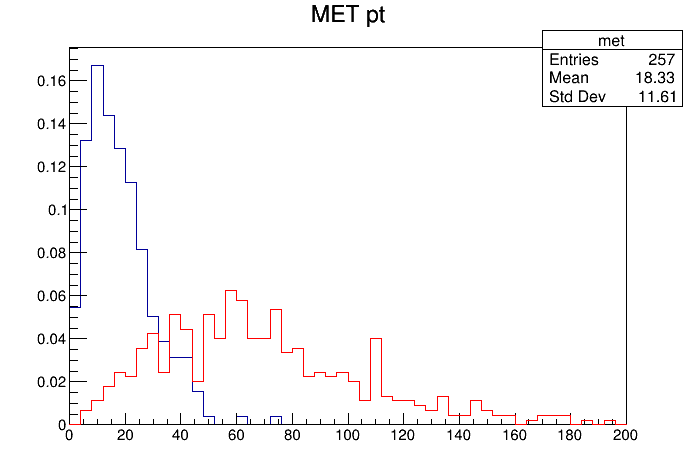

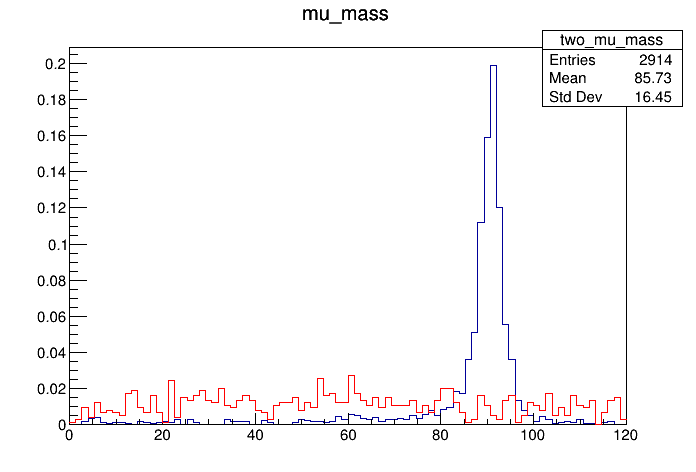

In [2]:
#jets
h_tt_je=ROOT.TH1F("Jet_e", "Jet e", 40, 20 , 200)
h_dy_je=ROOT.TH1F("Jet_e", "Jet e", 40, 20 , 200)
h_tt_jpt=ROOT.TH1F("Jet_pt", "Jet pt", 80, 20 , 150)
h_dy_jpt=ROOT.TH1F("Jet_pt", "Jet pt", 80, 20 , 150)
#met
h_tt_met=ROOT.TH1F("met", "MET pt", 50, 0 , 200)
h_dy_met=ROOT.TH1F("met", "MET pt", 50, 0 , 200)
#muoni
h_m_dy=ROOT.TH1F("two_mu_mass", "mu_mass", 90, 0, 120)
h_m_tt=ROOT.TH1F("two_mu_mass", "mu_mass", 90, 0, 120)

arr = [[h_tt_je,h_dy_je], [h_tt_jpt,h_dy_jpt], [h_tt_met,h_dy_met],[h_m_tt,h_m_dy]]

for i in range(tttr.GetEntries()):
    tttr.GetEntry(i)
    if(tttr.muontracks_size >=2):
        muons = pt.get_collection(tttr, "muontracks")
        passing = 0
        for mi in range(len(muons)):
            if(tttr.muontracks_dz[mi]<0.005 and tttr.muontracks_dB[mi]<0.003 and tttr.muontracks_isoDeposits[mi]<4):
                for mj in range(len(muons)):
                    if(mi!=mj and tttr.muontracks_dz[mj]<0.014 and tttr.muontracks_dB[mj]<0.007 and tttr.muontracks_isoDeposits[mj]<9):
                        passing = 1
                        s_mu = (muons[mi].p4+muons[mj].p4).M()
                        h_m_tt.Fill(s_mu)
        if(passing==1):
            #Taglio in distanza angolare jets-leptons + solo 2 jets più energetici
            jets = pt.get_collection(tttr, "jets") 
            if(len(jets)>=2):
                clean_jets = []             #jets con distanza angolare che ci piace
                sel_j = []                  #solo i 2 più energetici di ogni clean_jets
                for jj in range(len(jets)): #Selezione jets validi
                    dists=[]                #array di distanze angolari
                    for mm in range(len(muons)):
                        d = ROOT.TMath.Sqrt( ((muons[mm].eta - jets[jj].eta)*(muons[mm].eta - jets[jj].eta)) + ((muons[mm].phi - jets[jj].phi)*(muons[mm].phi -jets[jj].phi)) )
                        dists.append(d)
                    if(min(dists) > 0.4):
                        clean_jets.append(jets[jj])
                if(len(clean_jets)>1):              #non ha senso considerare l'evento se nella selezione resta un solo jet
                    for p in range(2):              #solo 2 per evento
                        sel_j.append(clean_jets[p]) #questi sono i jets che ci piacciono
                    h_tt_met.Fill(tttr.met_pt[0])

                    for jet in range(len(sel_j)):
                        h_tt_je.Fill(sel_j[jet].e)
                        h_tt_jpt.Fill(sel_j[jet].pt)

for k in range(dytr.GetEntries()):             #stesso ciclo di prima, ma sull'altro tree
    dytr.GetEntry(k)
    if(dytr.muontracks_size >=2):
        muons = pt.get_collection(dytr, "muontracks")
        passing = 0
        for mi in range(len(muons)):
            if(dytr.muontracks_dz[mi]<0.005 and dytr.muontracks_dB[mi]<0.003 and dytr.muontracks_isoDeposits[mi]<4):
                for mj in range(len(muons)):
                    if(mi!=mj and dytr.muontracks_dz[mj]<0.014 and dytr.muontracks_dB[mj]<0.007 and dytr.muontracks_isoDeposits[mj]<9): 
                        passing = 1
                        s_mu = (muons[mi].p4+muons[mj].p4).M()
                        h_m_dy.Fill(s_mu)
        if(passing==1):
            #Taglio in distanza angolare jets-leptons + solo 2 jets più energetici
            jets = pt.get_collection(dytr, "jets") 
            if(len(jets)>=2):
                clean_jets = []
                sel_j = []
                for jj in range(len(jets)):
                    dists=[]
                    for mm in range(len(muons)):
                        d = ROOT.TMath.Sqrt( ((muons[mm].eta - jets[jj].eta)*(muons[mm].eta - jets[jj].eta)) + ((muons[mm].phi - jets[jj].phi)*(muons[mm].phi -jets[jj].phi)) )
                        dists.append(d)
                    if(min(dists) > 0.4):
                        clean_jets.append(jets[jj])
                if(len(clean_jets)>1):
                    for p in range(2):
                        sel_j.append(clean_jets[p])
                    h_dy_met.Fill(dytr.met_pt[0])

                    for jet in range(len(sel_j)):
                        h_dy_je.Fill(sel_j[jet].e)
                        h_dy_jpt.Fill(sel_j[jet].pt)

c=list(np.zeros(4))
h_tts=[]
h_dys=[]
for i in arr:
    h_tts.append(i[0])
    h_dys.append(i[1])
for i in range(4):
    c[i]=ROOT.TCanvas()
    c[i].Draw()
    h_tts[i].Scale(1/h_tts[i].Integral())
    h_dys[i].Scale(1/h_dys[i].Integral())
    h_dys[i].Draw("hist")
    h_tts[i].SetLineColor(ROOT.kRed)
    h_tts[i].Draw("SAME,hist")

 FCN=52.0931 FROM MIGRAD    STATUS=CONVERGED      91 CALLS          92 TOTAL
                     EDM=3.13523e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.41558e+00   8.81671e-01   1.24069e-03  -7.04891e-04
   2  p1           1.22661e+01   8.29740e-01   1.16833e-03  -6.30830e-04
 FCN=66.0334 FROM MIGRAD    STATUS=CONVERGED      38 CALLS          39 TOTAL
                     EDM=1.87483e-15    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.58491e-02   1.22438e-03   3.14864e-04   1.57896e-04
   2  p1          -1.70025e-04   1.16869e-05   1.20000e-05   1.67017e-02


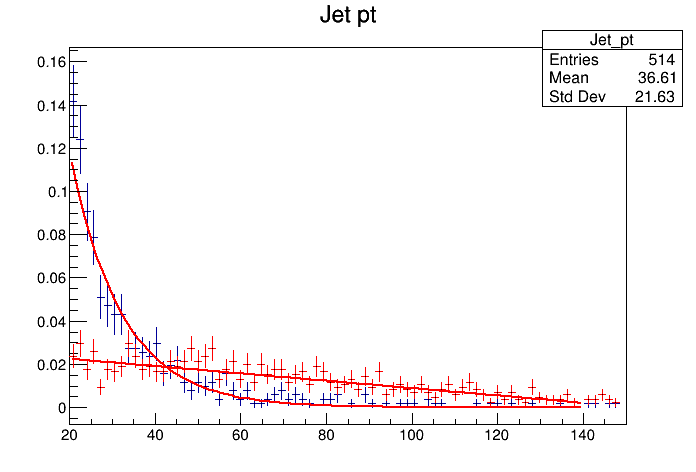

In [3]:
#[h_tt_je,h_dy_je]
#[h_tt_met,h_dy_met]

f_dyjpt = ROOT.TF1("gauss","[2]*1/([4]*TMath::Sqrt(2*TMath::Pi()))*exp(-(x-[3])*(x-[3])/(TMath::Sqrt(2)*[4]*[4]))")

c1=ROOT.TCanvas()
c1.Draw()

f_dy_jpt = ROOT.TF1("exp", "[0]/[1]*exp(-x/[1])",20,140)
f_tt_jpt = ROOT.TF1("retta", "[0]+[1]*x",20,140)
f_dy_jpt.SetParameters(1,4)
h_dy_jpt.Fit(f_dy_jpt,"SR")
h_dy_jpt.Draw()
h_tt_jpt.Draw("SAME")
f_tt_jpt.SetParameters(1,-4)
h_tt_jpt.Fit(f_tt_jpt,"SR")


In [4]:
bb= f_dy_jpt.Integral(45,140) #integrali nel cut >45
ss=f_tt_jpt.Integral(45,140)
bg_eff = bb/(bb+ss) *100
sig_eff = ss/(bb+ss)*100
print("signal efficiency cut:" ,sig_eff)

signal efficiency cut: 83.5661744358117


 FCN=15.2265 FROM MIGRAD    STATUS=CONVERGED     173 CALLS         174 TOTAL
                     EDM=6.93606e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.49059e+01   1.14005e+00   1.19703e-03  -4.62563e-04
   2  p1          -6.16103e+00   4.04601e-01   5.40915e-04  -3.64333e-04
   3  p2           8.50636e-01   1.27705e-01   1.07640e-04  -2.31163e-03
 FCN=54.596 FROM MIGRAD    STATUS=CONVERGED     214 CALLS         215 TOTAL
                     EDM=1.18727e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.18246e+01   2.18830e+00   6.05601e-03  -1.10541e-04
   2  p1          -1.26333e+01   5.74570e-01   1.67036e-03  -3.29963e-03
   3  p2           2.56800e-01   2

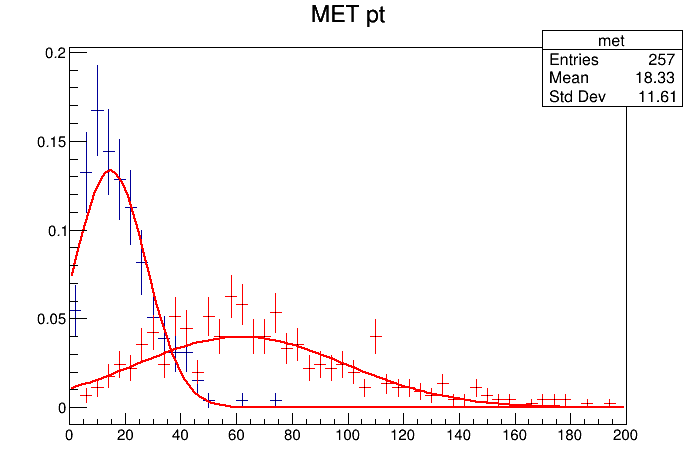

In [5]:
f_dy_metpt = ROOT.TF1("gauss","[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-(x-[0])*(x-[0])/(TMath::Sqrt(2)*[1]*[1]))",0,200)
f_tt_metpt = ROOT.TF1("gauss","[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-(x-[0])*(x-[0])/(TMath::Sqrt(2)*[1]*[1]))",0,200)

c2=ROOT.TCanvas()
c2.Draw()

f_dy_metpt.SetParameters(8,100,0.1)
h_dy_met.Fit(f_dy_metpt,"SR")
h_dy_met.Draw()

h_tt_met.Draw("SAME")
f_tt_metpt.SetParameters(50,3000,1)
h_tt_met.Fit(f_tt_metpt,"SR")

In [6]:
bb= f_dy_metpt.Integral(35,140) #integrali nel cut >35
ss=f_tt_metpt.Integral(35,140)
bg_eff = bb/(bb+ss) *100
sig_eff = ss/(bb+ss)*100
print("signal efficiency cut:" ,sig_eff)

signal efficiency cut: 91.65571429003113


 FCN=52.0814 FROM MIGRAD    STATUS=CALL LIMIT   1348 CALLS        1349 TOTAL
                     EDM=0.00245858    STRATEGY= 1  ERROR MATRIX UNCERTAINTY  22.0 per cent
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.83023e-01   2.15880e-01  -1.01767e-02  -3.59288e+00
   2  p1          -1.68114e+01   4.75689e-01   3.58928e-05   6.63711e-03
   3  p2           2.92632e+02   3.23295e+02   1.55365e+01  -2.34724e-03
 FCN=66.6354 FROM MIGRAD    STATUS=CONVERGED     193 CALLS         194 TOTAL
                     EDM=8.42247e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.36107e+01   4.91787e+00   7.35973e-03  -4.48104e-05
   2  p1          -1.83631e+01   1.00715e+00   1.85789e-03   1.98915e-03
   3  p2           3.

Warning in <Fit>: Abnormal termination of minimization.


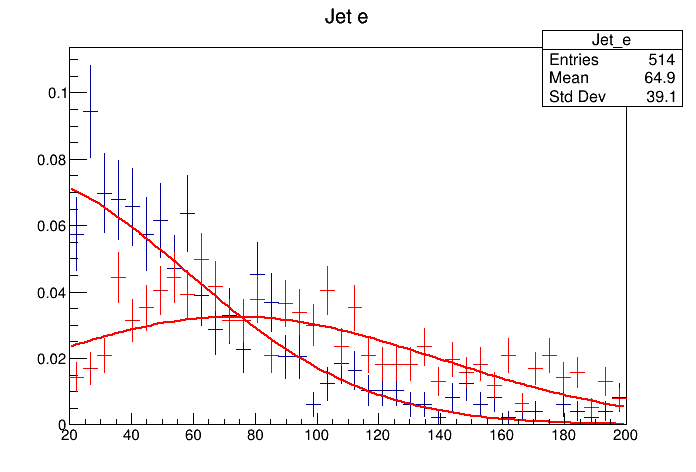

In [7]:
f_dy_je = ROOT.TF1("gauss","[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-(x-[0])*(x-[0])/(TMath::Sqrt(2)*[1]*[1]))",0,200)
f_tt_je = ROOT.TF1("gauss","[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-(x-[0])*(x-[0])/(TMath::Sqrt(2)*[1]*[1]))",0,200)

c3=ROOT.TCanvas()
c3.Draw()

f_dy_je.SetParameters(8,100,0.1)
h_dy_je.Fit(f_dy_metpt,"SR")
h_dy_je.Draw()

h_tt_je.Draw("SAME")
f_tt_je.SetParameters(50,3000,1)
h_tt_je.Fit(f_tt_je,"SR")

In [10]:
bb= f_dy_je.Integral(50,250) #integrali nel cut >60
ss=f_tt_je.Integral(50,250)

bg_eff = bb/(bb+ss) *100
sig_eff = ss/(bb+ss)*100
print("signal efficiency cut:" ,sig_eff)

signal efficiency cut: 99.81065819916154
